### Data Exploration for ScienceSage

- [Load Processed Data](#load-processed-data)
- [Duplicate Chunks](#duplicate-chunks)
- [Number of Articles and Chunks](#number-of-articles-and-chunks)
- [Category Distribution](#category-distribution)
- [Chunks per Article](#chunks-per-article)
- [Chunks per Source](#chunks-per-source)
- [Chunk Position Analysis](#chunk-position-analysis)
- [Image Coverage](#image-coverage)
- [Summary Length](#summary-length)
- [Word Count Analysis](#word-count-analysis)
- [Topic/Keyword Distribution (Word Cloud)](#topickeyword-distribution-word-cloud)
- [Name Entity Frequency](#name-entity-frequency)
- [Correlation Analysis between Numeric Features](#correlation-analysis-between-numeric-features)
- [Observations](#observations)

In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
import nltk

nltk.download("punkt", download_dir="/tmp")
nltk.download("stopwords", download_dir="/tmp")
nltk.data.path.append("/tmp")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /tmp...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /tmp...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
DATA_PATH = "../data/processed/chunks.jsonl"

### Load Processed Data

In [3]:
chunks = []
with open(DATA_PATH, "r") as f:
    for line in f:
        chunks.append(json.loads(line))

df = pd.DataFrame(chunks)
print(f"Loaded {len(df)} chunks.")

Loaded 2713 chunks.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   chunk_id     2713 non-null   object
 1   text         2713 non-null   object
 2   title        2713 non-null   object
 3   source_url   2713 non-null   object
 4   categories   2713 non-null   object
 5   topic        2713 non-null   object
 6   images       2713 non-null   object
 7   summary      2713 non-null   object
 8   chunk_index  2713 non-null   int64 
 9   char_start   2713 non-null   int64 
 10  char_end     2713 non-null   int64 
 11  created_at   2713 non-null   object
dtypes: int64(3), object(9)
memory usage: 254.5+ KB


In [5]:
df.head()

,chunk_id,text,title,source_url,categories,topic,images,summary,chunk_index,char_start,char_end,created_at
0,90a4913a-d951-5c8d-ac1b-ca7ff747285b,Discovery and exploration of the Solar System ...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:Discovery and exploration of the Sol...,other,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,0,0,836,2025-10-04T18:32:34.707453+00:00
1,1c506b7f-1495-5bb5-88d1-90931bf91239,Telescopic observations resulted in the discov...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:Discovery and exploration of the Sol...,other,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,1,836,1611,2025-10-04T18:32:34.707495+00:00
2,3a001811-fb43-5484-9f88-e64adee46a40,Observations of Solar System bodies with other...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:Discovery and exploration of the Sol...,other,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,2,1611,2401,2025-10-04T18:32:34.707522+00:00
3,7da092fd-22d0-55a4-98c9-bb2b0e82b3ab,Pre-telescope\nThe first humans had limited un...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:Discovery and exploration of the Sol...,other,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,3,2401,3073,2025-10-04T18:32:34.707544+00:00
4,7aa2ddd5-979c-514c-89b2-ba7d1c84e697,Many associated the classical planets (star-li...,Discovery and exploration of the Solar System,https://en.wikipedia.org/wiki/Discovery_and_ex...,[Category:Discovery and exploration of the Sol...,other,[https://upload.wikimedia.org/wikipedia/common...,Discovery and exploration of the Solar System ...,4,3073,4269,2025-10-04T18:32:34.707575+00:00


### Duplicate Chunks

In [6]:
duplicates = df.duplicated(subset=['text']).sum()
print(f"Number of duplicate chunks: {duplicates}")

Number of duplicate chunks: 0


In [7]:
dup_df = df[df.duplicated(subset=['text'], keep=False)]
print(dup_df[['title', 'source_url', 'text']].head(5))

Empty DataFrame
Columns: [title, source_url, text]
Index: []


In [8]:
# Are duplicates within the same article?
print(dup_df.groupby('title').size())

Series([], dtype: int64)


### Number of Articles and Chunks

In [9]:
print("Unique article titles:", df['title'].nunique())
print("Unique source URLs:", df['source_url'].nunique())

Unique article titles: 142
Unique source URLs: 142


### Category Distribution

In [10]:
if df['categories'].dtype == object and isinstance(df['categories'].iloc[0], str):
    df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [x])

all_categories = [cat for sublist in df['categories'] for cat in sublist]
cat_counts = Counter(all_categories)
top_cats = cat_counts.most_common(10)
print("Top categories:", top_cats)

Top categories: [('Category:Exploration of the Moon', 1158), ('Category:Exploration of Mars', 826), ('Category:Discovery and exploration of the Solar System', 655), ('Category:Solar System', 496), ('Category:Spaceflight', 379), ('Category:NASA programs', 348), ('Category:Space colonization', 267), ('Category:Spaceflight timelines', 265), ('Category:Missions to the Moon', 246), ('Category:Human missions to Mars', 226)]


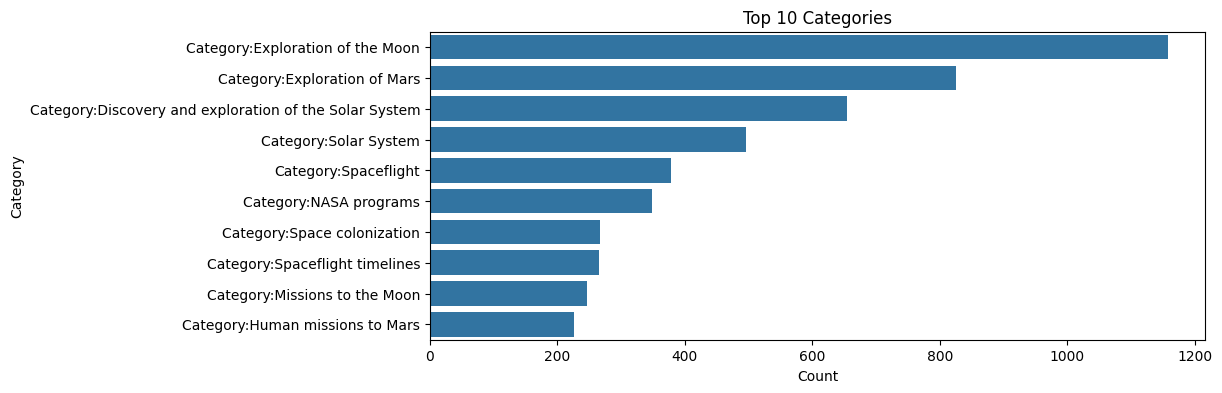

In [11]:
filtered_top_cats = [
    (cat, count) for cat, count in cat_counts.most_common()
    if not (cat.startswith("Category:Articles") or 
            cat.startswith("Category:CS1") or 
            cat.startswith("Category:Wikipedia") or 
            cat.startswith("Category:Pages") or 
            cat.startswith("Category:Vague") or 
            cat.startswith("Category:Use") or
            cat.startswith("Category:Short") or
            cat.startswith("Category:Webarchive") or
            cat.startswith("Category:All") or
            cat.startswith("Category:Commons"))][:10]

cats, counts = zip(*filtered_top_cats)
plt.figure(figsize=(10,4))
sns.barplot(x=list(counts), y=list(cats))
plt.title("Top 10 Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

### Chunks per Article

count    142.000000
mean      19.105634
std       18.844157
min        1.000000
25%        6.000000
50%       12.000000
75%       25.000000
max       88.000000
Name: chunk_index, dtype: float64


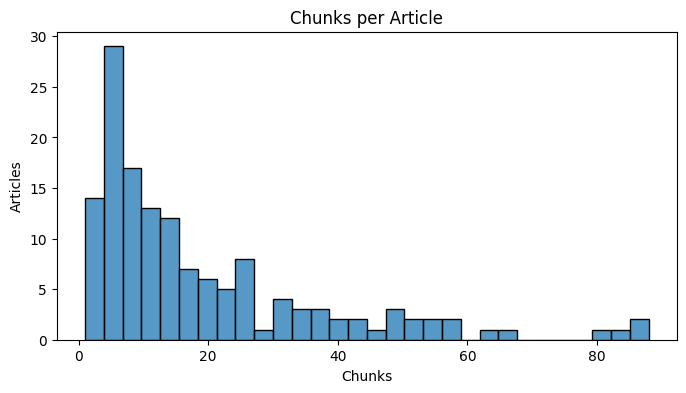

In [12]:
chunks_per_article = df.groupby('title')['chunk_index'].count()
print(chunks_per_article.describe())
plt.figure(figsize=(8,4))
sns.histplot(chunks_per_article, bins=30)
plt.title("Chunks per Article")
plt.xlabel("Chunks")
plt.ylabel("Articles")
plt.show()

### Chunks per Source

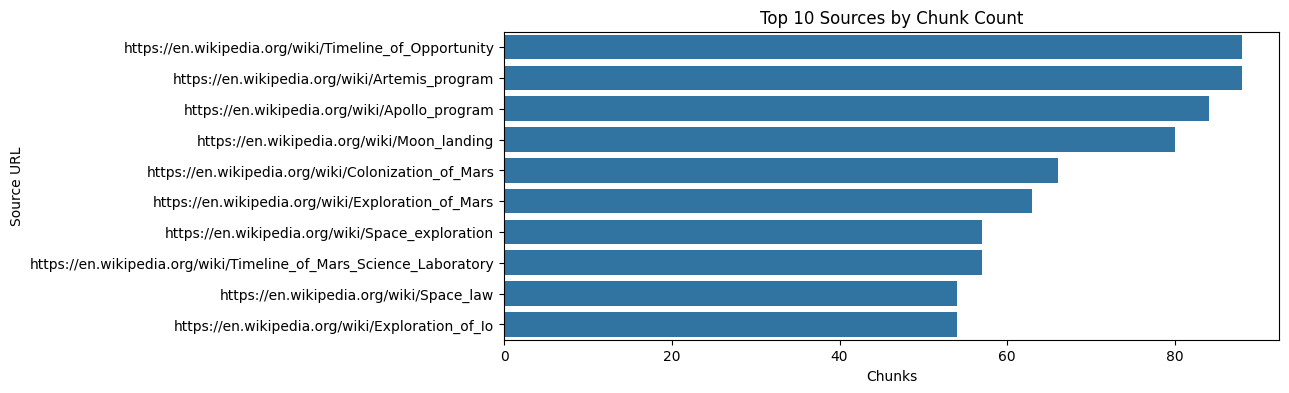

In [13]:
top_sources = df['source_url'].value_counts().head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_sources.values, y=top_sources.index)
plt.title("Top 10 Sources by Chunk Count")
plt.xlabel("Chunks")
plt.ylabel("Source URL")
plt.show()

### Chunk Position Analysis

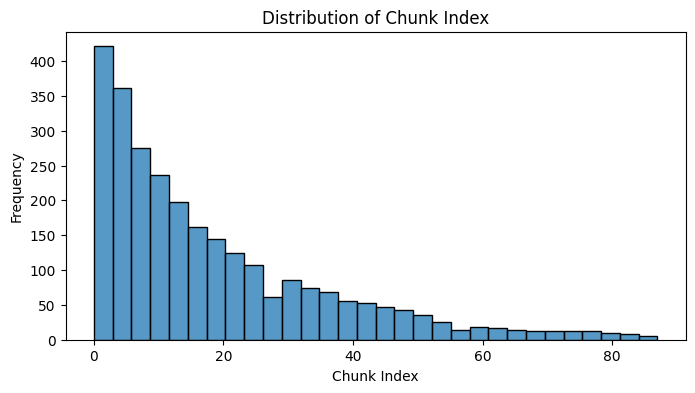

In [14]:
plt.figure(figsize=(8,4))
sns.histplot(df['chunk_index'], bins=30)
plt.title("Distribution of Chunk Index")
plt.xlabel("Chunk Index")
plt.ylabel("Frequency")
plt.show()

### Image Coverage

In [15]:
has_image = df['images'].apply(lambda x: bool(x) and x != '[]')
num_with_images = has_image.sum()
total_chunks = len(df)
percent_with_images = (num_with_images / total_chunks) * 100
print(f"Chunks with images: {num_with_images} / {total_chunks} ({percent_with_images:.2f}%)")

Chunks with images: 2563 / 2713 (94.47%)


### Chunks with and without Images by Category

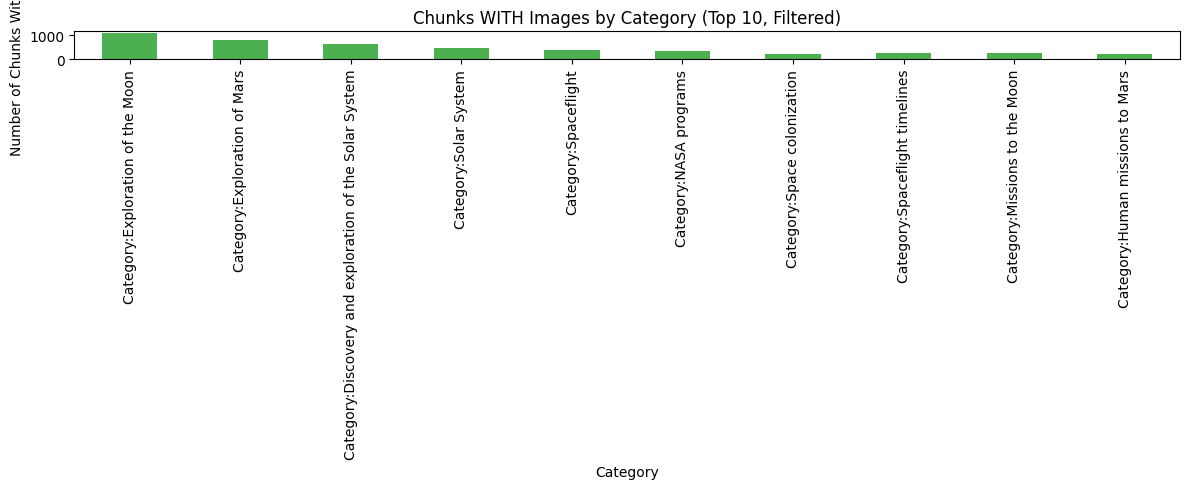

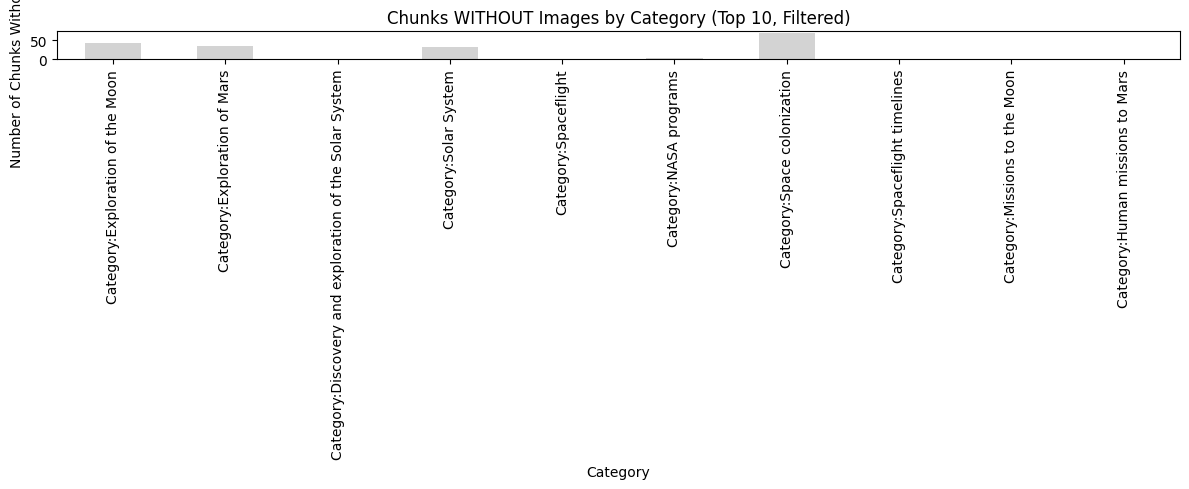

In [16]:
# Ensure categories are lists
if df['categories'].dtype == object and isinstance(df['categories'].iloc[0], str):
    df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [x])

# Create a flag for image presence
df['has_image'] = df['images'].apply(lambda x: bool(x) and x != '[]')

# Explode categories for per-category analysis
df_exploded = df.explode('categories')

# Filter out unwanted categories
def is_valid_category(cat):
    return not (
        cat.startswith("Category:Articles") or 
        cat.startswith("Category:CS1") or 
        cat.startswith("Category:Wikipedia") or 
        cat.startswith("Category:Pages") or 
        cat.startswith("Category:Vague") or 
        cat.startswith("Category:Use") or
        cat.startswith("Category:Short") or
        cat.startswith("Category:Webarchive") or
        cat.startswith("Category:All") or
        cat.startswith("Category:Commons")
    )

df_exploded_filtered = df_exploded[df_exploded['categories'].apply(is_valid_category)]

# Group by category and image flag
cat_img = df_exploded_filtered.groupby(['categories', 'has_image']).size().unstack(fill_value=0)

# Get top 10 categories by total count
top_cats = cat_img.sum(axis=1).sort_values(ascending=False).head(10).index
cat_img_top = cat_img.loc[top_cats]

# Plot chunks WITH images (True)
cat_img_top[True].plot(kind='bar', figsize=(12,5), color='#4caf50')
plt.title("Chunks WITH Images by Category (Top 10, Filtered)")
plt.xlabel("Category")
plt.ylabel("Number of Chunks With Images")
plt.tight_layout()
plt.show()

# Plot chunks WITHOUT images (False)
cat_img_top[False].plot(kind='bar', figsize=(12,5), color='#d3d3d3')
plt.title("Chunks WITHOUT Images by Category (Top 10, Filtered)")
plt.xlabel("Category")
plt.ylabel("Number of Chunks Without Images")
plt.tight_layout()
plt.show()

### Summary Length

In [17]:
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))
print(df['summary_length'].describe())

count    2713.000000
mean      208.370439
std       132.969298
min        19.000000
25%        99.000000
50%       192.000000
75%       289.000000
max       604.000000
Name: summary_length, dtype: float64


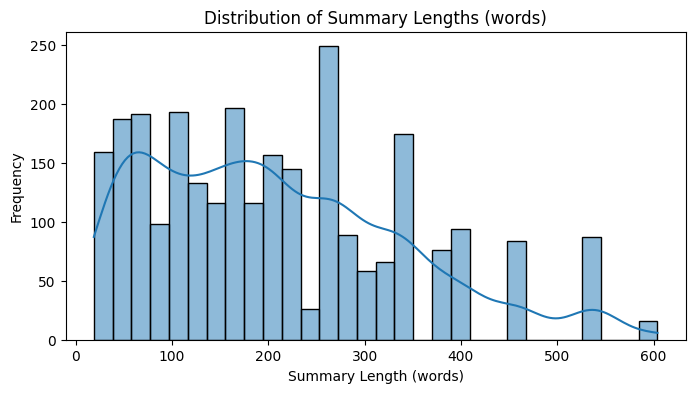

In [18]:
plt.figure(figsize=(8,4))
sns.histplot(df['summary_length'], bins=30, kde=True)
plt.title("Distribution of Summary Lengths (words)")
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.show()

In [19]:
percent_with_summary = (df['summary'].apply(lambda x: bool(str(x).strip())).sum() / len(df)) * 100
print(f"Chunks with non-empty summary: {percent_with_summary:.2f}%")

Chunks with non-empty summary: 100.00%


### Text Length vs. Summary Length

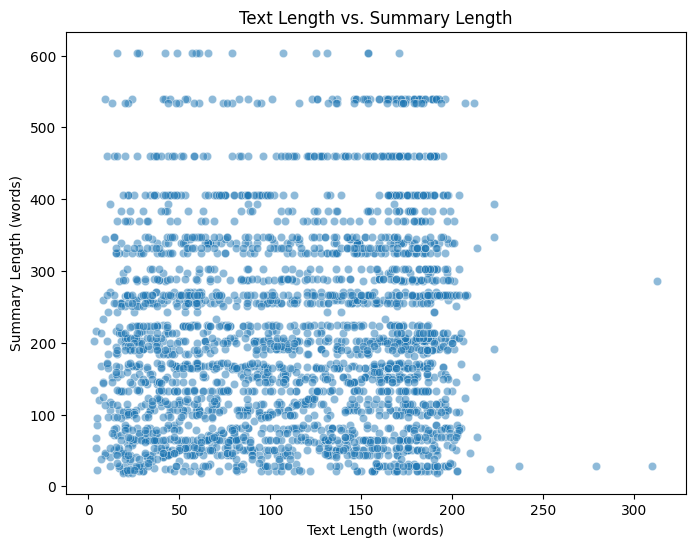

In [20]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,6))
sns.scatterplot(x='text_length', y='summary_length', data=df, alpha=0.5)
plt.title("Text Length vs. Summary Length")
plt.xlabel("Text Length (words)")
plt.ylabel("Summary Length (words)")
plt.show()

### Word Count Analysis

count    2713.000000
mean      111.714338
std        58.668101
min         3.000000
25%        58.000000
50%       114.000000
75%       167.000000
max       313.000000
Name: word_count, dtype: float64


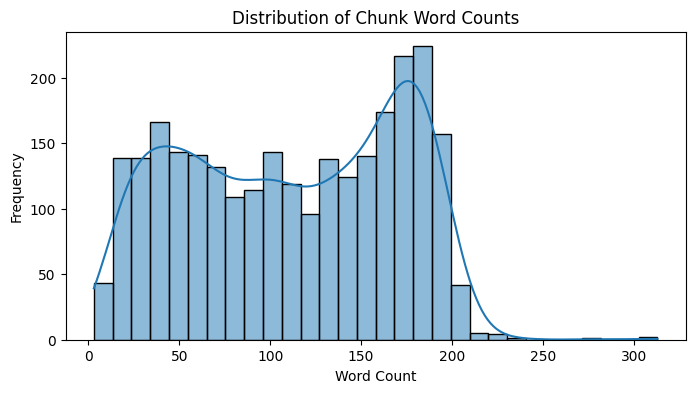

In [21]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df['word_count'].describe())

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Distribution of Chunk Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Topic/Keyword Distribution (Word Cloud)

In [22]:
months = [
    'january', 'february', 'march', 'april', 'may', 'june', 'july',
    'august', 'september', 'october', 'november', 'december',
    'jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'sept', 'oct', 'nov', 'dec'
]
stop_words.update(months)
stop_words.update(str(n) for n in range(0, 2100))  # covers years and most numbers

def preprocess(text):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

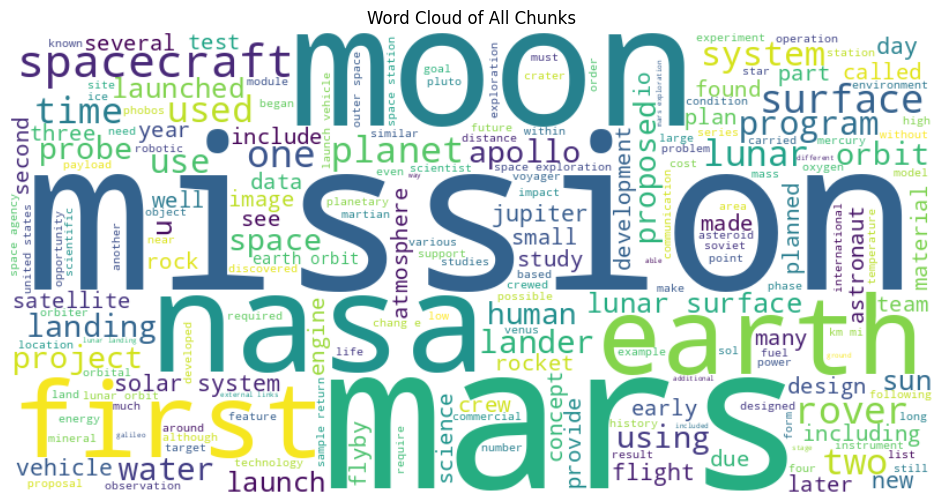

In [23]:
all_text = " ".join(df['text'].apply(preprocess).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Chunks")
plt.show()

### Names Entity Frequency

In [24]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.6 MB/s  0:00:00m0:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [25]:
nlp = spacy.load("en_core_web_sm")
entities = Counter()
for doc in nlp.pipe(df['text'].sample(min(100, len(df))), batch_size=20):
    entities.update([ent.label_ for ent in doc.ents])
print("Named entity counts (sample):", entities)

Named entity counts (sample): Counter({'ORG': 324, 'DATE': 259, 'PERSON': 180, 'CARDINAL': 133, 'LOC': 100, 'GPE': 78, 'NORP': 66, 'ORDINAL': 64, 'QUANTITY': 39, 'PRODUCT': 37, 'MONEY': 29, 'WORK_OF_ART': 20, 'LAW': 19, 'TIME': 15, 'PERCENT': 8, 'FAC': 7, 'LANGUAGE': 2, 'EVENT': 1})


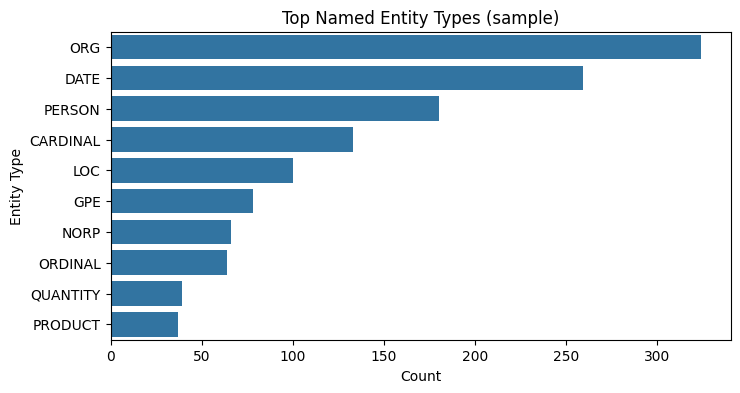

In [26]:
entity_labels, entity_counts = zip(*entities.most_common(10))
plt.figure(figsize=(8,4))
sns.barplot(x=list(entity_counts), y=list(entity_labels))
plt.title("Top Named Entity Types (sample)")
plt.xlabel("Count")
plt.ylabel("Entity Type")
plt.show()

### Correlation Analysis between Numeric Features

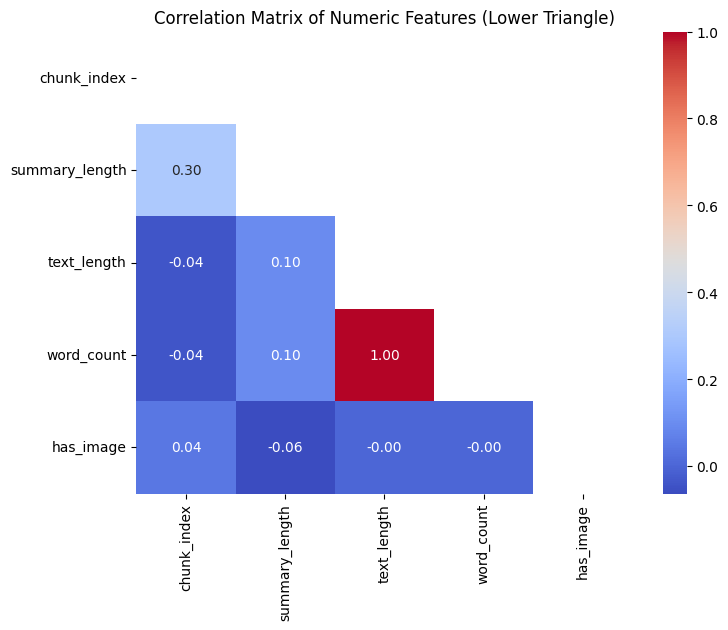

In [27]:
numeric_cols = [
    "chunk_index",
    "summary_length",
    "text_length",
    "word_count",
    "has_image"
]

# Ensure 'has_image' is numeric (0/1)
if "has_image" in df.columns and df["has_image"].dtype != int:
    df["has_image"] = df["has_image"].astype(int)

# Compute correlation matrix
corr = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features (Lower Triangle)")
plt.show()

### Observations

In [28]:
print(
    "=== Observations ===\n"
    f"- {len(df)} chunks\n"
    f"- {df['title'].nunique()} unique article titles and unique source URLs\n"
    f"- {df.duplicated(subset=['text']).sum()} duplicate chunks\n"
    f"- {df['summary'].apply(lambda x: bool(str(x).strip())).sum() / len(df) * 100:.2f}% of chunks have non-empty summary"
    f"- Created_at are essentially all the same, but put in there in case we decide to add more data later\n"
    f"- Most articles have {df.groupby('title').size().mean():.2f} chunks; the maximum number of chunks in an article is {df.groupby('title').size().max()} - these are for articles on the Apollo program, the Artemis program, and the timeline of the Opportunity Rover\n"
    f"- {df['has_image'].mean() * 100:.2f}% of the chunks have images associated with them\n"
    f"- Typical summary length is about {df['summary_length'].mean():.0f} words\n"
    f"- Both average and maximum chunk length is {df['text_length'].mean():.0f} and {df['text_length'].max()} (but we set that)\n"
    f"- Most popular topics were Moon, Mars, Earth, mission\n"
    f"- Most features are independent, except for text_length and word_count\n"
    f"- Summary length is somewhat related to chunk position and text length, but not strongly\n"
    f"- Image presence is almost independent of other features"
)

=== Observations ===
- 2713 chunks
- 142 unique article titles and unique source URLs
- 0 duplicate chunks
- 100.00% of chunks have non-empty summary- Created_at are essentially all the same, but put in there in case we decide to add more data later
- Most articles have 19.11 chunks; the maximum number of chunks in an article is 88 - these are for articles on the Apollo program, the Artemis program, and the timeline of the Opportunity Rover
- 94.47% of the chunks have images associated with them
- Typical summary length is about 208 words
- Both average and maximum chunk length is 112 and 313 (but we set that)
- Most popular topics were Moon, Mars, Earth, mission
- Most features are independent, except for text_length and word_count
- Summary length is somewhat related to chunk position and text length, but not strongly
- Image presence is almost independent of other features
